The full drift diffusin model with 

In [1]:
# Full drift diffusion model 
# September 2020, Clara Kuper

# This script implements noise free drift diffusion models that simulate the selection of action plans.

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from scipy.stats import uniform
import ipywidgets as widgets
from IPython.display import display

df = pd.read_csv('sim1000.csv')
df

,Unnamed: 0,trial,time,y_attacker,x_attacker,y_end_attacker,x_target,y_target,goal_mean,goal_upper,goal_lower,p_in,goal_upper_expand,goal_lower_expand,decision_expand,d_prime_expand
0,0,0.0,0.008333,-5.5,-20.00,-5.5,0.0,1.731510,0.0,4.0,-4.0,0.095874,1.731510,1.731510,correct_reject,0.0
1,1,0.0,0.054444,-5.5,-18.75,-5.5,0.0,-1.818140,0.0,4.0,-4.0,0.172343,1.731510,-1.818140,correct_reject,0.0
2,2,0.0,0.100556,-5.5,-17.50,-5.5,0.0,2.226061,0.0,4.0,-4.0,0.068870,2.226061,-1.818140,correct_reject,0.0
3,3,0.0,0.146667,-5.5,-16.25,-5.5,0.0,2.371570,0.0,4.0,-4.0,0.033312,2.371570,-1.818140,correct_reject,0.0
4,4,0.0,0.192778,-5.5,-15.00,-5.5,0.0,0.740505,0.0,4.0,-4.0,0.033312,2.371570,-1.818140,correct_reject,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,11,999.0,0.515556,5.5,-6.25,5.5,0.0,1.295679,0.0,4.0,-4.0,0.000000,3.884249,-3.327805,correct_reject,0.0
15996,12,999.0,0.561667,5.5,-5.00,5.5,0.0,-1.010079,0.0,4.0,-4.0,0.000000,3.884249,-3.327805,correct_reject,0.0
15997,13,999.0,0.607778,5.5,-3.75,5.5,0.0,2.134271,0.0,4.0,-4.0,0.000000,3.884249,-3.327805,correct_reject,0.0
15998,14,999.0,0.653889,5.5,-2.50,5.5,0.0,-2.166901,0.0,4.0,-4.0,0.000000,3.884249,-3.327805,correct_reject,0.0


In [2]:
# Set the parameters that will be estimated later:

thresh_drift = 0.01 #difference units drift
thresh_pause = 0.01 #difference units drift
dur_pause = 0.010 #in s
thresh_dec = 10 #drift


# Compute

# Step 1: Compute the certainty at each time step.
# We use a cumulative density function to estimate how likely the attacker is inside the goal.
# For that, we normalize the location of the goal (centered at "0") and collapse the space on one side.

def get_p_in(upper_known,lower_known,attacker,full_width):
    
    """
    Normalizes the upper and lower bounds to compute how likely the attacker is to hit the goal, given the distance between
    attacker and last known point of the goal
    
    input:
    upper_known: np array or pandas series, holding the presented upper part of the goal (can span several trials)
    lower_known: np array or pandas series, holding the lower presented part of the goal (can span several trials)
    attacker: np array or pandas series, holding the (estimated) end point of the attacker (must have as many entries as the two other vectors)
    full_width: the span that is covered by the full goal
    
    returns:
    P_in: the probability that the attacker is inside the goal (value between 0 and 1)
    
    """
    
    # part 1: normalize the values to be alligned with the mean of the known goal, and to have positive values
    mean_goal = (upper_known + lower_known)/2    
    upper_norm = abs(upper_known - mean_goal)
    lower_norm = abs(lower_known - mean_goal)
    attacker_norm = abs(attacker - mean_goal)
    
    # part 2: compute the covered and the unknown size of the goal
    covered_goal = abs(upper_known - lower_known)
    free_width = full_width - covered_goal

    # part 3: compute the probability that the attacker hits inside the goal
    p_in = 1 - uniform.cdf(attacker_norm, loc = upper_norm, scale = free_width)
    
    return p_in

full_width = abs(df['goal_upper'][0]-df['goal_lower'][0])

p_in = get_p_in(df['goal_upper_expand'],df['goal_lower_expand'],df['y_end_attacker'],full_width)

In [3]:
# Find the difference between probabilities from stimulus to stimulus
# add a zero in front to get the first entry
p_in_pad = np.hstack([0,p_in])
# compute absolute difference
p_in_diff = abs(np.diff(p_in_pad))
# replace the beginning of a new trial with the initial probability
zero_idx = np.where(df.iloc[:,0]==0)
p_in_diff[zero_idx] = p_in[zero_idx]
df['p_in'] = p_in
df['p_in_diff'] = p_in_diff

In [4]:
# Compute the reaction time, for each trial, drift till threshold is reached, substract not needed reaction time
def get_RT(trial_data,thresh_dec,thresh_pause,thresh_drift,dur_pause,offset = 0):
    
    """
    Get the reaction time for a single trial
    input:
    trial_data: pandas data set with one line per new stimulus, all from one trial, contains at least the fields "p_in", "p_in_diff",
    "time"
    thresh_dec: the boundary for a "go" decision
    thresh_pause: the boundary to stop a motor plan
    thresh_drift: the boundary to change the drift rate
    dur_pause: the duration of a drift stop
    
    output: RT, reaction time in seconds
    """
    
    dec = offset
    drift = trial_data['p_in']
    # normalize the drift rate so that it can be positive and negative:
    drift = drift - 0.5
    diff = trial_data['p_in_diff']
    # find the time between presentations of one stimulus 
    delta_t = trial_data['time'].iloc[1]-trial_data['time'].iloc[0]
    
    # intialize some values
    idx = 0
    drift_val = 0
    
    # while the decison threshold is not crossed and the trial is not over:
    while abs(dec) < thresh_dec and idx<15:
        
        # Check if the new drift rate is taken
        # For now, we use the difference between two points to adjust this, not the difference between the currently 
        # used drift and the newly suggested drift
        if diff.iloc[idx]>thresh_drift:
            drift_val = drift.iloc[idx]*1000
        
        # compute if we need to stop
        stop_reached = diff.iloc[idx]-thresh_pause
        
        # drift and stop if needed
        delta_dec = drift_val*(delta_t - np.heaviside(stop_reached,1)*dur_pause)
        dec += delta_dec
        idx += 1
    
    #compute the duration of one trial
    duration = trial_data['time'].iloc[idx]
    
    #compute the distance to the "true" threshold and set this as reaction time.
    overshoot = abs(dec)-thresh_dec
    #define the response in this trial (which boundary was reached)
    go_no = np.heaviside(dec,0.5)
    
    RT = duration - overshoot/drift_val
    return RT, go_no
    
RT, go_no = get_RT(df[0:15],thresh_dec,thresh_pause,thresh_drift,dur_pause)

In [5]:
# Get the reaction time and decision for every 
trials = np.unique(df['trial'])
RTs = np.zeros(len(trials))

In [6]:
for trial in trials:
    idx_trial = np.where(df['trial'] == trial)[0]
    trial_data = df.iloc[idx_trial]
    
    RTs[int(trial)], go = get_RT(trial_data,thresh_dec,thresh_pause,thresh_drift,dur_pause)

C:\Users\ClaraQ\anaconda3\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in double_scalars


(array([517., 219., 106.,  46.,  26.,  10.,   5.,   2.,   2.,   1.]),
 array([0.03835637, 0.0939002 , 0.14944403, 0.20498786, 0.26053168,
        0.31607551, 0.37161934, 0.42716317, 0.482707  , 0.53825083,
        0.59379465]),
 <a list of 10 Patch objects>)

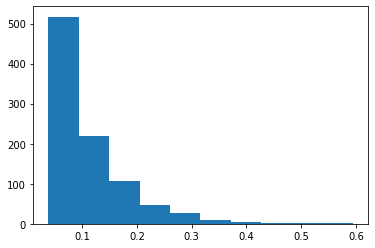

In [7]:
inf_vals = np.where(RTs == float('inf'))

RTs = np.delete(RTs,inf_vals)
fig1, axs1 = plt.subplots(1,1)
axs1.hist(RTs)

In [47]:
drift_slider = widgets.FloatSlider(min=0,
    max=0.2,
    step=0.001,
    description='Threshold to change drift:',
    value=0.01) #difference units drift
pause_slider = widgets.FloatSlider(min=0,
    max=0.2,
    step=0.001,
    description='Threshold to pause:',
    value=0.01) #difference units drift
dur_pause_slider = widgets.FloatSlider(min=0,
    max=0.4,
    step=0.002,
    description='How long to pause:',
    value=0.01) #in s
dec_slider = widgets.FloatSlider(min=0,
    max=500,
    step=0.1,
    description='Threshold to make a desision:',
    value=10) #drift

    
display(drift_slider, pause_slider, dur_pause_slider, dec_slider)

FloatSlider(value=0.01, description='Threshold to change drift:', max=0.2, step=0.001)

FloatSlider(value=0.01, description='Threshold to pause:', max=0.2, step=0.001)

FloatSlider(value=0.01, description='How long to pause:', max=0.4, step=0.002)

FloatSlider(value=10.0, description='Threshold to make a desision:', max=500.0)

C:\Users\ClaraQ\anaconda3\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in double_scalars


(array([152., 105.,  88.,  49.,  47.,  40.,  48.,  38.,  44.,  32.,  30.,
         23.,  17.,  20.,  19.,  15.,  15.,  13.,  11.,   8.]),
 array([0.  , 0.03, 0.06, 0.09, 0.12, 0.15, 0.18, 0.21, 0.24, 0.27, 0.3 ,
        0.33, 0.36, 0.39, 0.42, 0.45, 0.48, 0.51, 0.54, 0.57, 0.6 ]),
 <a list of 20 Patch objects>)

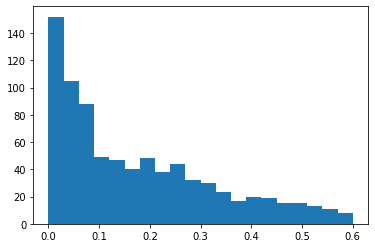

In [56]:
thresh_drift = drift_slider.value #difference units drift
thresh_pause = pause_slider.value #difference units drift
dur_pause = dur_pause_slider.value #in s
thresh_dec = dec_slider.value #drift

RTs = np.zeros(len(trials))
for trial in trials:
    idx_trial = np.where(df['trial'] == trial)[0]
    trial_data = df.iloc[idx_trial]
    
    RTs[int(trial)], go = get_RT(trial_data,thresh_dec,thresh_pause,thresh_drift,dur_pause)
    
inf_vals = np.where(RTs == float('inf'))

RTs = np.delete(RTs,inf_vals)
fig2, axs2 = plt.subplots(1,1)
axs2.hist(RTs,range = (0,0.6), bins = 20)

625